# SHAP Values

Veremos brevemente un modelo de interpretabilidad para modelos complejos de machine learning como es un LGBM.

El uso de **python** para esta exploración se debe a la madurez encontrada en las librerías en mi búsqueda.

Empezamos con la carga de los módulos necesarios:

In [181]:
import pandas as pd
import numpy as np

import lightgbm as lgb

Cargamos con **pandas** lentamente el dataset. Sólo vamos a trabajar con el primer conjunto de datos que es el más pequeño. Con un poco más de paciencia podrá usar los conjuntos más pesados. 

In [182]:
df_train = pd.read_csv("../../../datasets/competencia3_2022.csv")

Columns (154) have mixed types. Specify dtype option on import or set low_memory=False.


In [183]:
Xtrain = df_train[(df_train["foto_mes"] >= 202006) & (df_train["foto_mes"] <= 202105)]
ytrain = Xtrain["clase_ternaria"].map(lambda x: 0 if x == "CONTINUA" else 1)

Separamos también todos los casos de **BAJAS+1** y **BAJAS+2**

In [184]:
Xbajas = df_train.query("foto_mes >= 202006 and foto_mes <= 202105 and clase_ternaria != 'CONTINUA'")
Xbajas2 = df_train.query("foto_mes >= 202006 and foto_mes <= 202105 and clase_ternaria != 'CONTINUA'")

In [185]:
print(Xtrain.shape)
print(ytrain.shape)
print(Xbajas.shape)

(1914297, 155)
(1914297,)
(17365, 155)


Y nos deshacemos del target y limpiamos un poco la memoria.

In [186]:
Xtrain = Xtrain.drop("clase_ternaria", axis=1)
Xbajas = Xbajas.drop("clase_ternaria", axis=1)
Xtrain = Xtrain.drop("foto_mes", axis=1)
Xbajas = Xbajas.drop("foto_mes", axis=1)
Xtrain = Xtrain.drop("numero_de_cliente", axis=1)
Xbajas = Xbajas.drop("numero_de_cliente", axis=1)

del(df_train)

## Hacemos un modelo **LGBM**

In [187]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(Xtrain, ytrain)

# specify your configurations as a dict
params = {
    'objective': 'binary',
    'learning_rate': 0.05,
    'verbose': 2,
    'max_bin': 15,
    'min_data_in_leaf': 4000,
    'verbose': 0,
}

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=100)


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.270550 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


## Importancia de variables

In [188]:
lgbm_importancia = pd.DataFrame({'Features': gbm.feature_name(),
                        'Importances': gbm.feature_importance()})
lgbm_importancia.sort_values(by='Importances', inplace=True, ascending=False)
lgbm_importancia


,Features,Importances
70,mcomisiones_mantenimiento,139
6,mrentabilidad_annual,128
31,mprestamos_personales,117
14,mcuenta_corriente,101
105,ctrx_quarter,97
...,...,...
108,Master_delinquency,0
112,Master_Finiciomora,0
32,cprestamos_prendarios,0
115,Master_msaldodolares,0


## Obtenemos shap values

Ahora avanzamos aplicando un modelo de interpretabilidad sobre el modelo anterior.

In [189]:
import shap

In [190]:
explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(Xbajas)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Consolidamos los valores de **SHAP** para cada variable y para cada **BAJA+\***

In [191]:
shap_bajas = pd.DataFrame(shap_values[0], columns = Xbajas.columns)
shap_bajas

,active_quarter,cliente_vip,internet,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,mactivos_margen,mpasivos_margen,...,Visa_madelantodolares,Visa_fultimo_cierre,Visa_mpagado,Visa_mpagospesos,Visa_mpagosdolares,Visa_fechaalta,Visa_mconsumototal,Visa_cconsumos,Visa_cadelantosefectivo,Visa_mpagominimo
0,0.038667,0.0,-0.042561,-0.014870,-0.009548,0.135636,-0.110289,-0.003304,-0.055059,-0.014986,...,0.0,0.004167,0.000004,-0.056260,-0.000586,-0.020015,0.0,-0.020722,0.0,-0.016447
1,0.032194,0.0,-0.037401,-0.097180,-0.011394,0.081335,-0.092515,-0.003304,-0.051677,-0.009403,...,0.0,0.003919,-0.004096,-0.054779,-0.000586,-0.020524,0.0,-0.021556,0.0,-0.015670
2,0.052091,0.0,-0.031984,0.002431,0.035571,0.180737,-0.069410,-0.004469,-0.057114,-0.028487,...,0.0,-0.003768,0.001345,-0.058924,-0.000586,0.047094,0.0,-0.044142,0.0,-0.063880
3,0.025637,0.0,-0.030997,0.018439,-0.007049,0.178751,-0.124126,-0.002024,-0.036807,-0.039369,...,0.0,-0.000872,0.000554,-0.073326,0.000069,-0.021905,0.0,-0.017479,0.0,-0.114934
4,0.056615,0.0,-0.018158,-0.063293,-0.002447,0.053613,-0.054777,-0.004843,-0.031557,0.011367,...,0.0,0.001826,0.002252,0.030878,-0.000840,0.000876,0.0,0.108120,0.0,0.055430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17360,-0.011691,0.0,-0.044464,0.011971,0.013132,0.079849,-0.109748,-0.009396,0.107006,-0.027591,...,0.0,-0.000331,0.000451,0.022455,0.000069,0.007533,0.0,0.008611,0.0,-0.021497
17361,0.029148,0.0,-0.026161,-0.109477,0.064972,0.074785,-0.048340,-0.005035,-0.062078,-0.020746,...,0.0,-0.000980,0.002548,-0.050172,-0.000586,0.046753,0.0,-0.030817,0.0,-0.051767
17362,-0.007726,0.0,-0.062600,-0.017524,0.051940,-0.020102,-0.040360,-0.008709,-0.097971,-0.047964,...,0.0,-0.002185,0.000931,-0.026508,-0.000586,0.028768,0.0,-0.017434,0.0,-0.058561
17363,0.035107,0.0,-0.026672,-0.009743,0.027216,0.068165,-0.028639,-0.004492,-0.049236,-0.020540,...,0.0,-0.001418,0.001710,-0.060587,-0.000586,0.057996,0.0,-0.033203,0.0,-0.048911


Y consolidamos sus importancias

In [192]:
shap_importancias = shap_bajas.abs().mean().sort_values(ascending=False)
shap_importancias

ctrx_quarter             0.991077
cpayroll_trx             0.506228
mpayroll                 0.330444
mprestamos_personales    0.227798
mcaja_ahorro             0.207787
                           ...   
Master_delinquency       0.000000
Master_Finiciomora       0.000000
cprestamos_prendarios    0.000000
Master_msaldodolares     0.000000
cforex_sell              0.000000
Length: 152, dtype: float64

In [193]:
df_shap_imp = pd.DataFrame({'column': shap_importancias.index, 'value': shap_importancias.values})
df_shap_imp[0:20]

,column,value
0,ctrx_quarter,0.991077
1,cpayroll_trx,0.506228
2,mpayroll,0.330444
3,mprestamos_personales,0.227798
4,mcaja_ahorro,0.207787
5,mcomisiones_mantenimiento,0.177324
6,mcuentas_saldo,0.147950
7,Visa_msaldopesos,0.137189
8,Visa_msaldototal,0.131313
9,mcuenta_corriente,0.113824


In [194]:
shap_importancias.index

Index(['ctrx_quarter', 'cpayroll_trx', 'mpayroll', 'mprestamos_personales',
       'mcaja_ahorro', 'mcomisiones_mantenimiento', 'mcuentas_saldo',
       'Visa_msaldopesos', 'Visa_msaldototal', 'mcuenta_corriente',
       ...
       'minversion1_pesos', 'mplazo_fijo_pesos', 'mpayroll2', 'matm',
       'catm_trx_other', 'Master_delinquency', 'Master_Finiciomora',
       'cprestamos_prendarios', 'Master_msaldodolares', 'cforex_sell'],
      dtype='object', length=152)

## Visualizar shap_values

La librería nos da útiles herramientas para vizualizar la info anterior

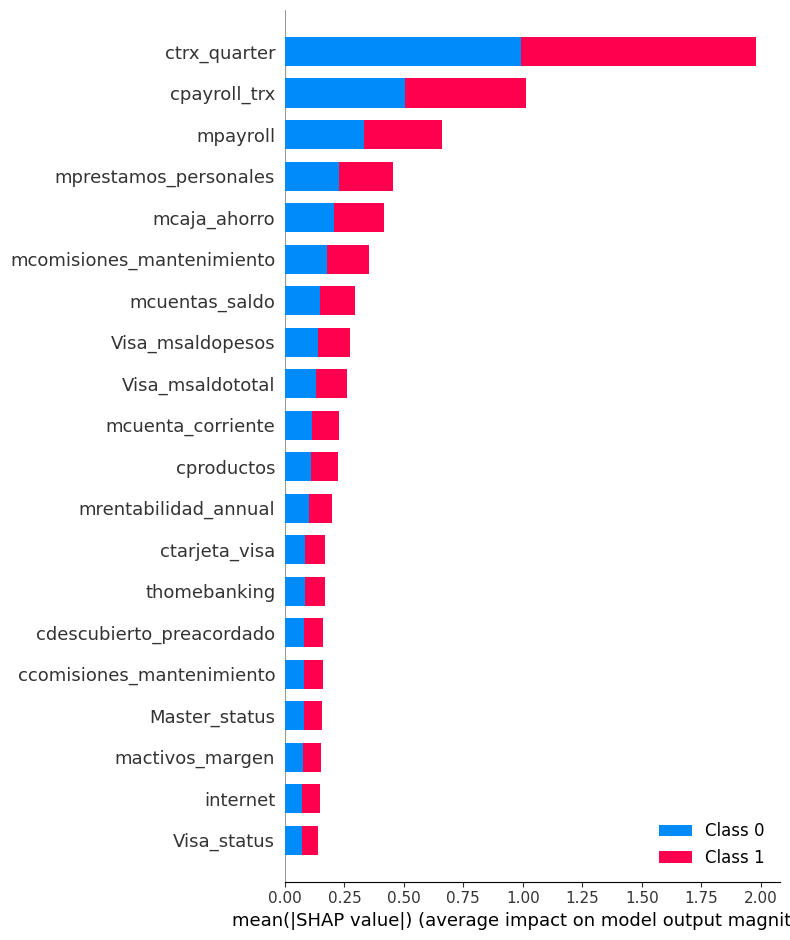

In [195]:
summary_plot = shap.summary_plot(shap_values, Xbajas)

Y ahora debemos empezar a jugar para entender como estan asociadas las variables a los **shap values**

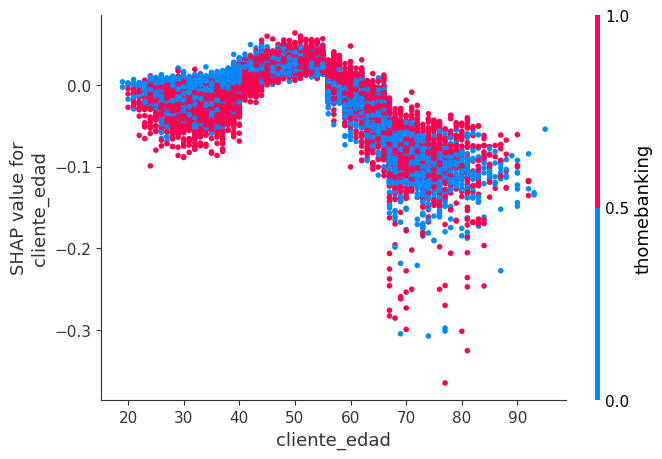

In [196]:
shap.dependence_plot("cliente_edad", shap_values[0], Xbajas)

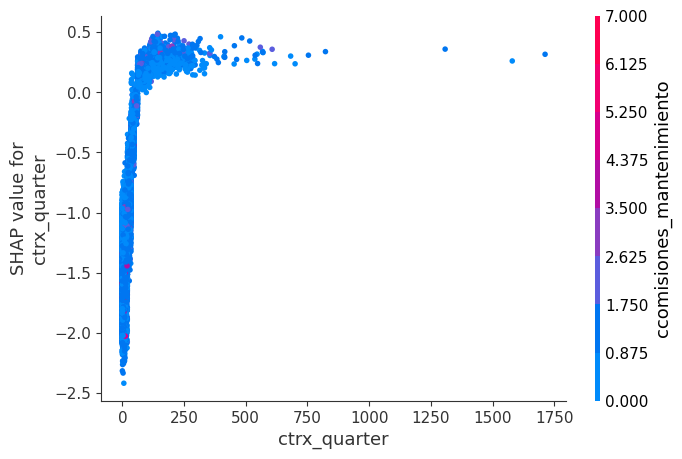

In [197]:
shap.dependence_plot("ctrx_quarter", shap_values[0], Xbajas)

## Clustering

¿Se podrá hacer una clusterización sobre los valores de shap? 

Como la cantidad de variables es muy alto, es conveniente hacer un embedding con **UMAP**. Como la estrutura de los **shap values** se pueden hacer sin mucho preprocesamiento.

In [198]:
from umap import UMAP
import matplotlib.pyplot as plt


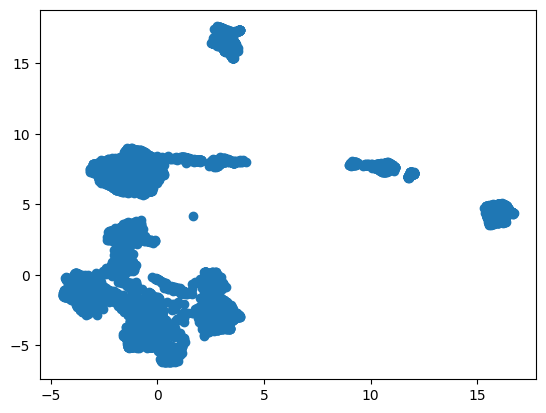

In [199]:
embedding_2d = UMAP(
  n_components=2, n_neighbors=500, random_state=123
).fit_transform(shap_values[0])
plt.scatter(embedding_2d[:,0], embedding_2d[:,1])

In [200]:
embedding_2d.shape

(17365, 2)

In [201]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn_extra.cluster import KMedoids

In [202]:
k =3
clusterer = KMedoids(n_clusters=k, random_state=100)
cluster_labels = clusterer.fit_predict(embedding_2d)
centers = clusterer.cluster_centers_

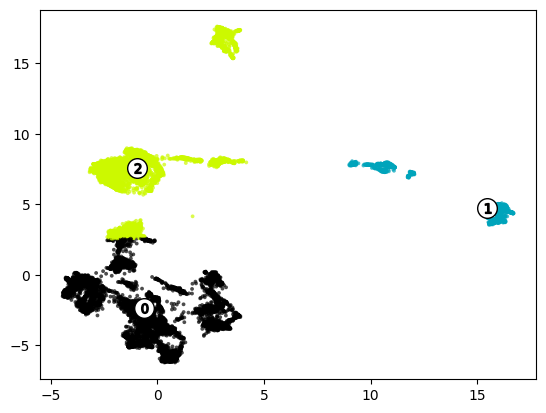

In [203]:
datos = embedding_2d
colors = cm.nipy_spectral(cluster_labels.astype(float) / k)
plt.scatter(
    datos[:, 0], datos[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
)

# Draw white circles at cluster centers
plt.scatter(
    centers[:, 0],
    centers[:, 1],
    marker="o",
    c="white",
    alpha=1,
    s=200,
    edgecolor="k",
)

for i, c in enumerate(centers):
    plt.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

In [204]:
Xbajas.iloc[clusterer.medoid_indices_][['ctrx_quarter', 'mpayroll', 'cpayroll_trx', 'mprestamos_personales', 
                                        'mtarjeta_visa_consumo', 'mcuentas_saldo', 'mrentabilidad_annual', 
                                        'mactivos_margen', 'mcaja_ahorro', 'mcomisiones_mantenimiento', 
                                        'cliente_edad']]

,ctrx_quarter,mpayroll,cpayroll_trx,mprestamos_personales,mtarjeta_visa_consumo,mcuentas_saldo,mrentabilidad_annual,mactivos_margen,mcaja_ahorro,mcomisiones_mantenimiento,cliente_edad
4106714,32,0.0,0,0.0,0.0,-14579.73,9659.57,-19.74,0.00,2505.95,55
2447471,7,0.0,0,0.0,0.0,0.00,0.00,0.00,28.62,645.52,40
2386489,46,0.0,0,0.0,0.0,0.00,0.00,0.00,64224.33,0.00,68


In [205]:
cluster_labels

array([0, 0, 0, ..., 2, 0, 2], dtype=int64)

In [206]:
clusterer.medoid_indices_

array([15916,  1145,   524], dtype=int64)

In [207]:
df_labels = pd.DataFrame(cluster_labels, columns=['cluster'], index = Xbajas.index)
df_labels

,cluster
2300114,0
2300141,0
2300332,0
2300437,0
2301610,2
...,...
4213695,0
4213904,0
4214146,2
4214285,0


In [208]:
Xbajas = Xbajas.join(df_labels["cluster"])

In [209]:
Xbajas

,active_quarter,cliente_vip,internet,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,mactivos_margen,mpasivos_margen,...,Visa_fultimo_cierre,Visa_mpagado,Visa_mpagospesos,Visa_mpagosdolares,Visa_fechaalta,Visa_mconsumototal,Visa_cconsumos,Visa_cadelantosefectivo,Visa_mpagominimo,cluster
2300114,0,0,0,59,250,0.00,0.00,0.00,0.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2300141,0,0,0,69,258,0.00,0.00,0.00,0.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2300332,0,0,0,40,12,0.00,0.00,0.00,0.00,0.00,...,-1.0,0.0,NaN,NaN,316.0,NaN,NaN,NaN,0.00,0
2300437,0,0,0,52,313,0.00,0.00,0.00,0.00,0.00,...,-1.0,0.0,0.00,0.00,5180.0,387.03,1.0,0.0,0.00,0
2301610,0,0,0,71,254,0.00,0.00,0.00,0.00,0.00,...,-1.0,0.0,-42302.07,301.77,5476.0,145721.59,23.0,0.0,72256.80,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4213695,1,0,0,46,8,-5475.63,-12933.53,0.00,-4707.86,39.80,...,5.0,0.0,-5173.10,0.00,222.0,0.00,0.0,0.0,574.77,0
4213904,0,0,0,73,6,154.40,1550.48,0.00,131.63,0.00,...,5.0,0.0,NaN,NaN,165.0,NaN,NaN,NaN,0.00,0
4214146,1,0,0,31,3,152.73,816.88,71.61,0.00,69.16,...,5.0,0.0,NaN,NaN,47.0,NaN,NaN,NaN,0.00,2
4214285,0,0,0,66,2,0.00,0.00,0.00,0.00,0.00,...,5.0,0.0,NaN,NaN,47.0,NaN,NaN,NaN,0.00,0


In [210]:
Xbajas.groupby(['cluster']).size()

cluster
0    9066
1    1834
2    6465
dtype: int64

In [211]:
Xbajas[Xbajas['cluster'] == 1]

,active_quarter,cliente_vip,internet,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,mactivos_margen,mpasivos_margen,...,Visa_fultimo_cierre,Visa_mpagado,Visa_mpagospesos,Visa_mpagosdolares,Visa_fechaalta,Visa_mconsumototal,Visa_cconsumos,Visa_cadelantosefectivo,Visa_mpagominimo,cluster
2301965,0,0,0,67,254,0.00,0.00,0.00,0.00,0.00,...,-1.0,0.0,NaN,NaN,3345.0,NaN,NaN,NaN,0.00,1
2303169,0,0,0,56,106,0.00,0.00,0.00,0.00,0.00,...,-1.0,0.0,-4996.98,0.0,3229.0,771.18,2.0,0.0,0.00,1
2304758,0,0,0,85,313,0.00,0.00,0.00,0.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2304811,0,0,0,62,22,0.00,0.00,0.00,0.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2305299,0,0,0,79,274,0.00,0.00,0.00,0.00,0.00,...,-1.0,0.0,2487.24,0.0,7840.0,0.00,0.0,0.0,0.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4210742,1,0,0,35,20,1354.07,-6612.85,244.34,4937.09,-3991.03,...,5.0,0.0,-3607.43,0.0,294.0,0.00,0.0,0.0,3413.43,1
4211326,1,0,0,40,18,1220.22,50463.60,0.00,1029.43,10.83,...,5.0,0.0,-92558.90,0.0,539.0,0.00,0.0,0.0,0.00,1
4211709,1,0,0,34,17,15722.93,22149.10,1592.20,12042.54,4.12,...,12.0,0.0,-120030.89,0.0,496.0,0.00,0.0,0.0,2158.32,1
4212366,0,0,0,24,13,3866.02,20442.09,3063.46,684.19,0.00,...,5.0,0.0,NaN,NaN,371.0,NaN,NaN,NaN,0.00,1


In [212]:
shap_importancias.index

Index(['ctrx_quarter', 'cpayroll_trx', 'mpayroll', 'mprestamos_personales',
       'mcaja_ahorro', 'mcomisiones_mantenimiento', 'mcuentas_saldo',
       'Visa_msaldopesos', 'Visa_msaldototal', 'mcuenta_corriente',
       ...
       'minversion1_pesos', 'mplazo_fijo_pesos', 'mpayroll2', 'matm',
       'catm_trx_other', 'Master_delinquency', 'Master_Finiciomora',
       'cprestamos_prendarios', 'Master_msaldodolares', 'cforex_sell'],
      dtype='object', length=152)

## Resumenes

In [213]:
Xbajas.groupby(['cluster']).agg({
    'ctrx_quarter': ['min', 'max', 'mean', 'median']
})

ctrx_quarter                        
                 min   max       mean median
cluster                                     
0                  0    35  11.205824    9.0
1                  0   333  12.628680    3.0
2                  0  1713  68.190410   51.0

In [244]:
Xbajas["cluster"] = Xbajas["cluster"].astype(str)

<AxesSubplot: >

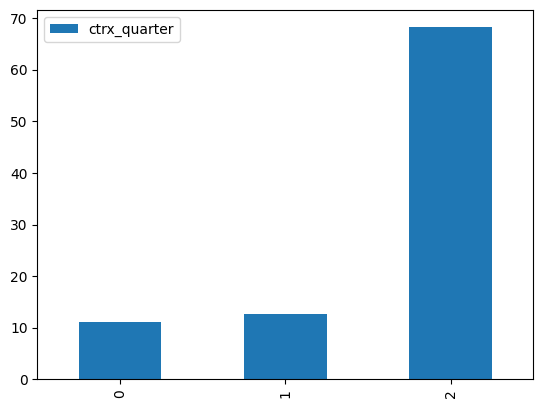

In [253]:
ctrx_quarter = Xbajas.groupby('cluster', as_index=False)["ctrx_quarter"].mean()
ctrx_quarter.plot(kind = "bar")

In [169]:
Xbajas.groupby(['cluster']).agg({
    'cpayroll_trx': ['min', 'max', 'mean', 'median'],
    'mpayroll': ['min', 'max', 'mean', 'median']
})

cpayroll_trx                      mpayroll                            \
                 min max      mean median      min         max          mean   
cluster                                                                        
0                  0   0  0.000000    0.0      0.0     1173.00      0.129385   
1                  0   2  0.003817    0.0      0.0     7855.58      9.657655   
2                  0  19  0.255530    0.0      0.0  8840856.28  18001.680526   

                
        median  
cluster         
0          0.0  
1          0.0  
2          0.0

<AxesSubplot: >

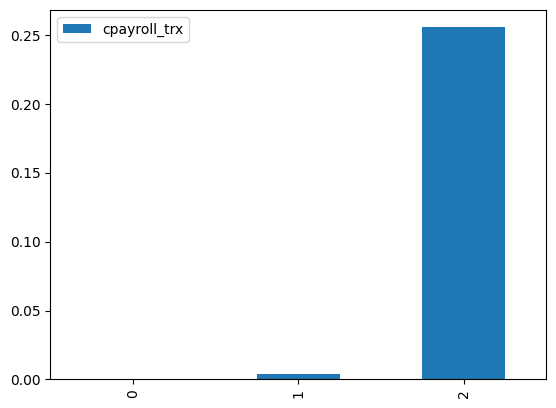

In [254]:
cpayroll_trx = Xbajas.groupby('cluster', as_index=False)["cpayroll_trx"].mean()
cpayroll_trx.plot(kind = "bar")

<AxesSubplot: >

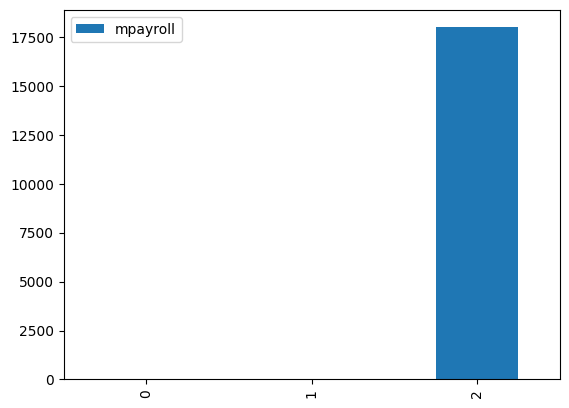

In [255]:
mpayroll = Xbajas.groupby('cluster', as_index=False)["mpayroll"].mean()
mpayroll.plot(kind = "bar")

In [170]:
Xbajas.groupby(['cluster']).agg({
    'mprestamos_personales': ['min', 'max', 'mean', 'median']
})

mprestamos_personales                                 
                          min         max          mean median
cluster                                                       
0                         0.0    27849.26    551.990272    0.0
1                         0.0   572924.87   1344.405682    0.0
2                         0.0  1372139.34  18623.310614    0.0

<AxesSubplot: >

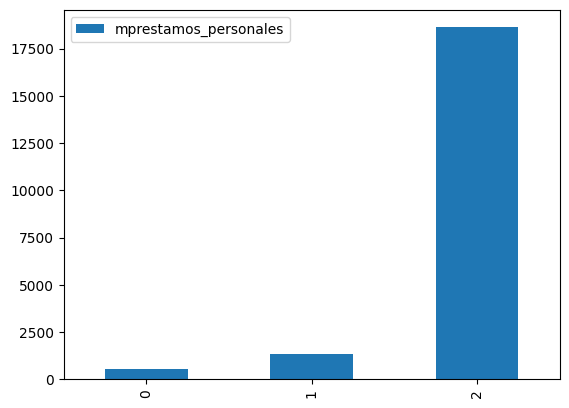

In [256]:
mprestamos_personales = Xbajas.groupby('cluster', as_index=False)["mprestamos_personales"].mean()
mprestamos_personales.plot(kind = "bar")

In [171]:
Xbajas.groupby(['cluster']).agg({
    'mcaja_ahorro': ['min', 'max', 'mean', 'median'],
})

mcaja_ahorro                                   
                 min         max          mean   median
cluster                                                
0                0.0  2742788.96   1899.755548     0.00
1                0.0  2073078.58   7042.142165     0.00
2                0.0  5140391.06  33521.217992  6400.83

<AxesSubplot: >

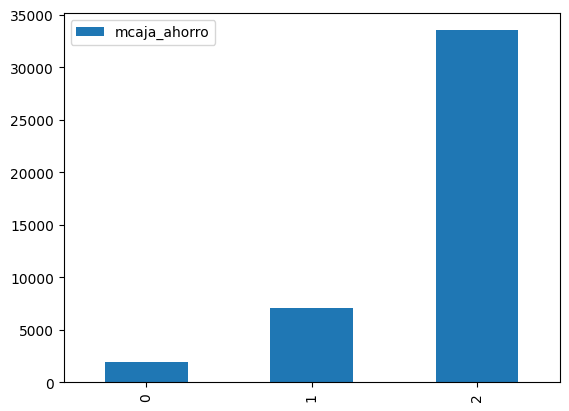

In [257]:
mcaja_ahorro = Xbajas.groupby('cluster', as_index=False)["mcaja_ahorro"].mean()
mcaja_ahorro.plot(kind = "bar")

In [172]:
Xbajas.groupby(['cluster']).agg({
    'mcomisiones_mantenimiento': ['min', 'max', 'mean', 'median']
})

mcomisiones_mantenimiento                              
                              min      max        mean   median
cluster                                                        
0                       -13130.79  4090.11  970.162957  1364.94
1                       -11569.06  3947.05  791.426309     0.53
2                        -8598.79  4469.03  883.265884   682.47

<AxesSubplot: >

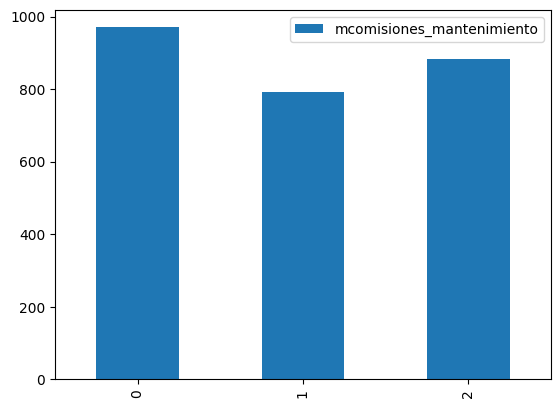

In [258]:
mcomisiones_mantenimiento = Xbajas.groupby('cluster', as_index=False)["mcomisiones_mantenimiento"].mean()
mcomisiones_mantenimiento.plot(kind = "bar")

In [173]:
Xbajas.groupby(['cluster']).agg({
    'mcuentas_saldo': ['min', 'max', 'mean', 'median']
})

mcuentas_saldo                                     
                   min          max          mean    median
cluster                                                    
0          -1225968.19  13925723.96   5461.820082 -1442.530
1          -2499007.33   4521803.48 -38537.629002 -8433.725
2          -1347146.44  14392871.70  61083.649111  2922.840

<AxesSubplot: >

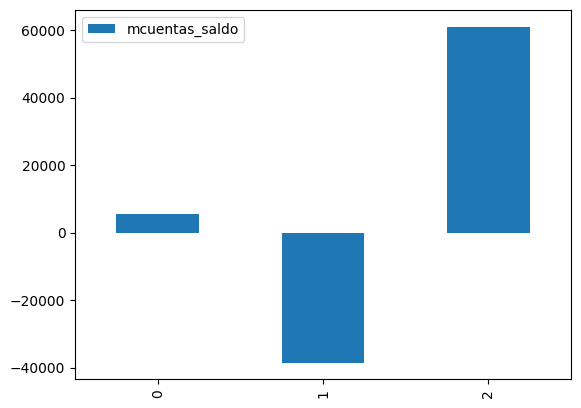

In [259]:
mcuentas_saldo = Xbajas.groupby('cluster', as_index=False)["mcuentas_saldo"].mean()
mcuentas_saldo.plot(kind = "bar")

In [174]:
Xbajas.groupby(['cluster']).agg({
    'Visa_msaldopesos': ['min', 'max', 'mean', 'median'],
    'Visa_msaldototal': ['min', 'max', 'mean', 'median']
})

Visa_msaldopesos                                     Visa_msaldototal  \
                     min         max          mean    median              min   
cluster                                                                         
0             -303338.22   819754.38   4988.199497     0.000       -258600.36   
1             -282750.57  1686362.07  34578.874482     0.000       -241049.08   
2              -92535.11  1610380.08  20962.650425  5234.185        -78887.57   

                                             
                max          mean    median  
cluster                                      
0         698852.84   4312.635909     0.000  
1        1437648.83  29667.434124     0.000  
2        1372873.05  18279.344954  4443.135

<AxesSubplot: >

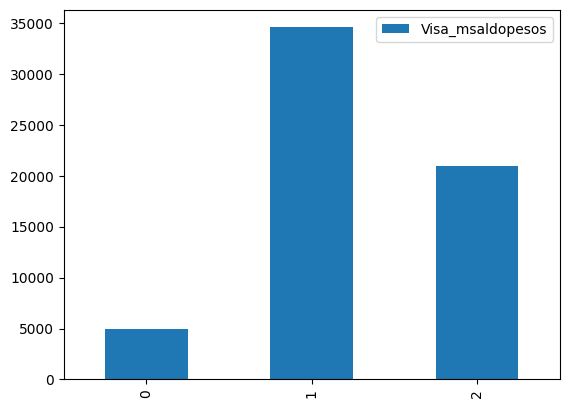

In [260]:
Visa_msaldopesos = Xbajas.groupby('cluster', as_index=False)["Visa_msaldopesos"].mean()
Visa_msaldopesos.plot(kind = "bar")

<AxesSubplot: >

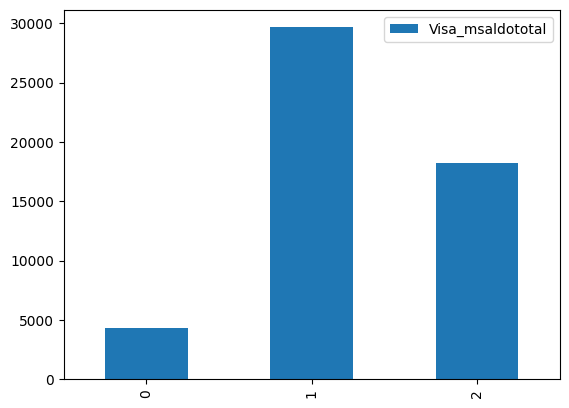

In [261]:
Visa_msaldototal = Xbajas.groupby('cluster', as_index=False)["Visa_msaldototal"].mean()
Visa_msaldototal.plot(kind = "bar")

In [175]:
Xbajas.groupby(['cluster']).agg({
    'mcuenta_corriente': ['min', 'max', 'mean', 'median']
})

mcuenta_corriente                                     
                      min         max          mean     median
cluster                                                       
0              -861465.73   222500.93  -5784.358015   -906.485
1             -2503322.81   546719.40 -61941.800649 -11230.455
2             -1372480.76  3397193.77  -2432.301357     -3.380

<AxesSubplot: >

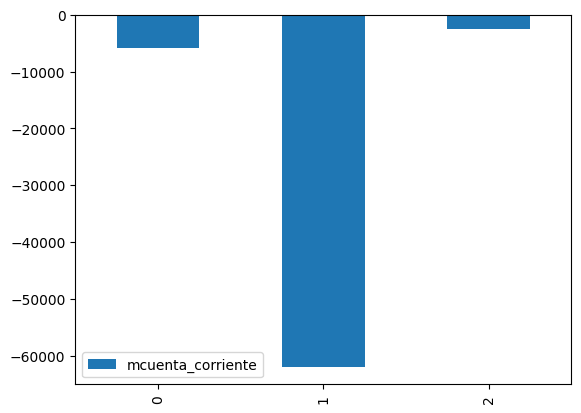

In [262]:
mcuenta_corriente = Xbajas.groupby('cluster', as_index=False)["mcuenta_corriente"].mean()
mcuenta_corriente.plot(kind = "bar")

In [176]:
Xbajas.groupby(['cluster']).agg({
    'cproductos': ['min', 'max', 'mean', 'median']
})


cproductos                     
               min max      mean median
cluster                                
0                3  11  6.169093    6.0
1                3  11  5.110142    5.0
2                3  14  6.860015    7.0

<AxesSubplot: >

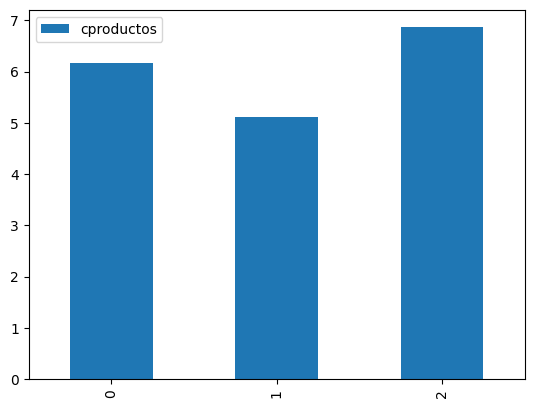

In [263]:
cproductos = Xbajas.groupby('cluster', as_index=False)["cproductos"].mean()
cproductos.plot(kind = "bar")

In [177]:
Xbajas.groupby(['cluster']).agg({
    'mrentabilidad_annual': ['min', 'max', 'mean', 'median']
})

mrentabilidad_annual                                    
                         min         max          mean    median
cluster                                                         
0                 -435564.75   919537.76  10814.827461   6251.56
1                 -210278.71   738563.75  18748.014967  10596.45
2                 -181477.65  2190080.78  18878.907007  10186.32

<AxesSubplot: >

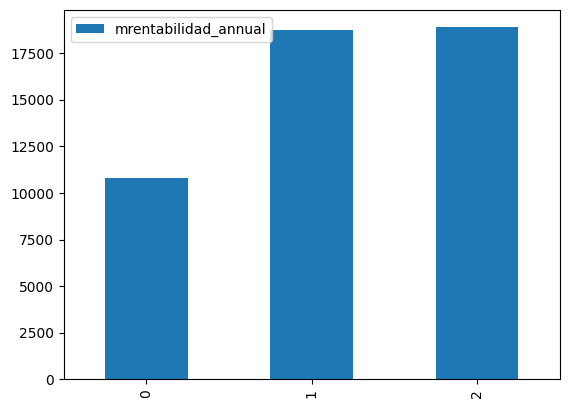

In [264]:
mrentabilidad_annual = Xbajas.groupby('cluster', as_index=False)["mrentabilidad_annual"].mean()
mrentabilidad_annual.plot(kind = "bar")

In [178]:
Xbajas.groupby(['cluster']).agg({
    'thomebanking': ['min', 'max', 'mean', 'median']
})

thomebanking                     
                 min max      mean median
cluster                                  
0                  0   1  0.422458    0.0
1                  0   1  0.285714    0.0
2                  0   1  0.706419    1.0

<AxesSubplot: >

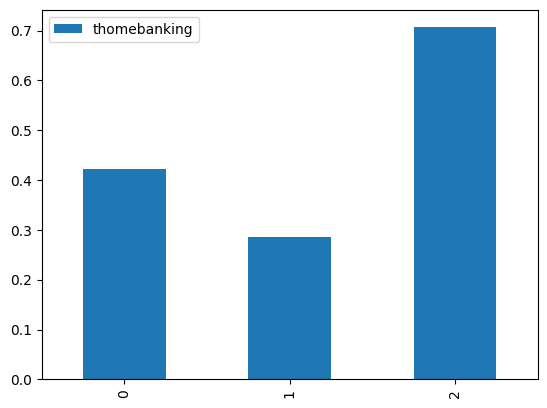

In [265]:
thomebanking = Xbajas.groupby('cluster', as_index=False)["thomebanking"].mean()
thomebanking.plot(kind = "bar")

In [266]:
Xbajas.groupby(['cluster']).agg({
    'cliente_edad': ['min', 'max', 'mean', 'median']
})

cliente_edad                      
                 min max       mean median
cluster                                   
0                 21  93  48.472976   47.0
1                 19  95  48.359324   46.0
2                 20  92  48.657231   47.0

## shap values por cluster

### cluster 0

In [154]:
Xbajas_c0 = Xbajas[Xbajas['cluster'] == 0]
Xbajas_c0 = Xbajas_c0.drop("cluster", axis = 1)

In [155]:
shap_values_c0 = explainer.shap_values(Xbajas_c0)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [156]:
shap_bajas_c0 = pd.DataFrame(shap_values_c0[0], columns = Xbajas_c0.columns)
shap_bajas_c0

,active_quarter,cliente_vip,internet,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,mactivos_margen,mpasivos_margen,...,Visa_madelantodolares,Visa_fultimo_cierre,Visa_mpagado,Visa_mpagospesos,Visa_mpagosdolares,Visa_fechaalta,Visa_mconsumototal,Visa_cconsumos,Visa_cadelantosefectivo,Visa_mpagominimo
0,0.038667,0.0,-0.042561,-0.014870,-0.009548,0.135636,-0.110289,-0.003304,-0.055059,-0.014986,...,0.0,0.004167,0.000004,-0.056260,-0.000586,-0.020015,0.0,-0.020722,0.0,-0.016447
1,0.032194,0.0,-0.037401,-0.097180,-0.011394,0.081335,-0.092515,-0.003304,-0.051677,-0.009403,...,0.0,0.003919,-0.004096,-0.054779,-0.000586,-0.020524,0.0,-0.021556,0.0,-0.015670
2,0.052091,0.0,-0.031984,0.002431,0.035571,0.180737,-0.069410,-0.004469,-0.057114,-0.028487,...,0.0,-0.003768,0.001345,-0.058924,-0.000586,0.047094,0.0,-0.044142,0.0,-0.063880
3,0.025637,0.0,-0.030997,0.018439,-0.007049,0.178751,-0.124126,-0.002024,-0.036807,-0.039369,...,0.0,-0.000872,0.000554,-0.073326,0.000069,-0.021905,0.0,-0.017479,0.0,-0.114934
4,0.033805,0.0,-0.034970,-0.095716,-0.008173,0.057366,-0.085439,-0.004563,-0.062730,-0.023216,...,0.0,-0.002070,0.002533,-0.065164,-0.000586,-0.013046,0.0,-0.045573,0.0,-0.102766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9061,0.020767,0.0,-0.059318,-0.011202,0.080443,-0.178136,-0.216778,0.000331,-0.076395,-0.064057,...,0.0,-0.000460,0.000516,-0.031819,-0.000586,0.116232,0.0,-0.017805,0.0,-0.093949
9062,-0.014994,0.0,-0.042027,-0.012636,0.016269,0.065371,-0.188384,-0.007849,0.042454,-0.066704,...,0.0,-0.000952,0.000349,0.027617,0.000069,0.015114,0.0,0.055515,0.0,0.056018
9063,-0.011691,0.0,-0.044464,0.011971,0.013132,0.079849,-0.109748,-0.009396,0.107006,-0.027591,...,0.0,-0.000331,0.000451,0.022455,0.000069,0.007533,0.0,0.008611,0.0,-0.021497
9064,0.029148,0.0,-0.026161,-0.109477,0.064972,0.074785,-0.048340,-0.005035,-0.062078,-0.020746,...,0.0,-0.000980,0.002548,-0.050172,-0.000586,0.046753,0.0,-0.030817,0.0,-0.051767


In [157]:
shap_importancias_c0 = shap_bajas_c0.abs().mean().sort_values(ascending=False)
shap_importancias_c0

ctrx_quarter             1.272334
cpayroll_trx             0.470326
mpayroll                 0.333643
mcaja_ahorro             0.245601
mprestamos_personales    0.231878
                           ...   
Master_delinquency       0.000000
Master_Finiciomora       0.000000
cprestamos_prendarios    0.000000
Master_msaldodolares     0.000000
cforex_sell              0.000000
Length: 152, dtype: float64

In [158]:
df0_shap_imp = pd.DataFrame({'column': shap_importancias_c0.index, 'value': shap_importancias_c0.values})
df0_shap_imp[0:20]

,column,value
0,ctrx_quarter,1.272334
1,cpayroll_trx,0.470326
2,mpayroll,0.333643
3,mcaja_ahorro,0.245601
4,mprestamos_personales,0.231878
5,mcomisiones_mantenimiento,0.193209
6,Visa_msaldopesos,0.156173
7,mcuentas_saldo,0.150118
8,Visa_msaldototal,0.134578
9,mcuenta_corriente,0.109389


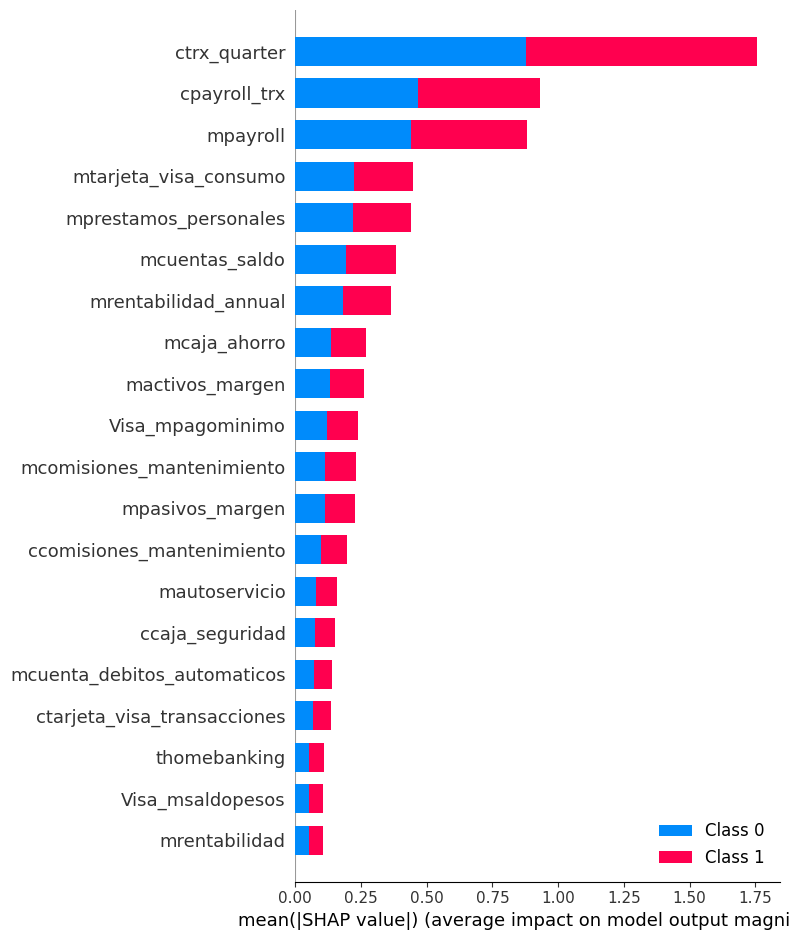

In [ ]:
summary_plot = shap.summary_plot(shap_values_c0, Xbajas_c0)

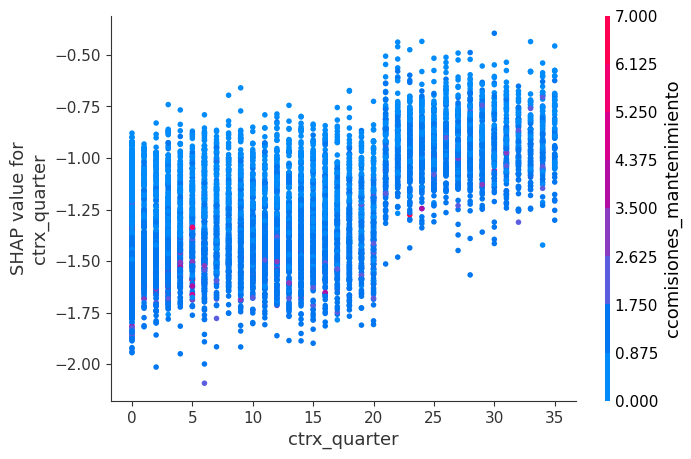

In [159]:
shap.dependence_plot("ctrx_quarter", shap_values_c0[0], Xbajas_c0)

### cluster 1

In [160]:
Xbajas_c1 = Xbajas[Xbajas['cluster'] == 1]
Xbajas_c1 = Xbajas_c1.drop("cluster", axis = 1)
shap_values_c1 = explainer.shap_values(Xbajas_c1)
shap_bajas_c1 = pd.DataFrame(shap_values_c1[0], columns = Xbajas_c1.columns)
shap_importancias_c1 = shap_bajas_c1.abs().mean().sort_values(ascending=False)
shap_importancias_c1

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


ctrx_quarter               1.588554
cpayroll_trx               0.503617
Visa_status                0.469043
mcuenta_corriente          0.384423
Master_status              0.365166
                             ...   
Master_msaldodolares       0.000000
Master_mconsumospesos      0.000000
Master_madelantopesos      0.000000
Master_madelantodolares    0.000000
cforex_sell                0.000000
Length: 152, dtype: float64

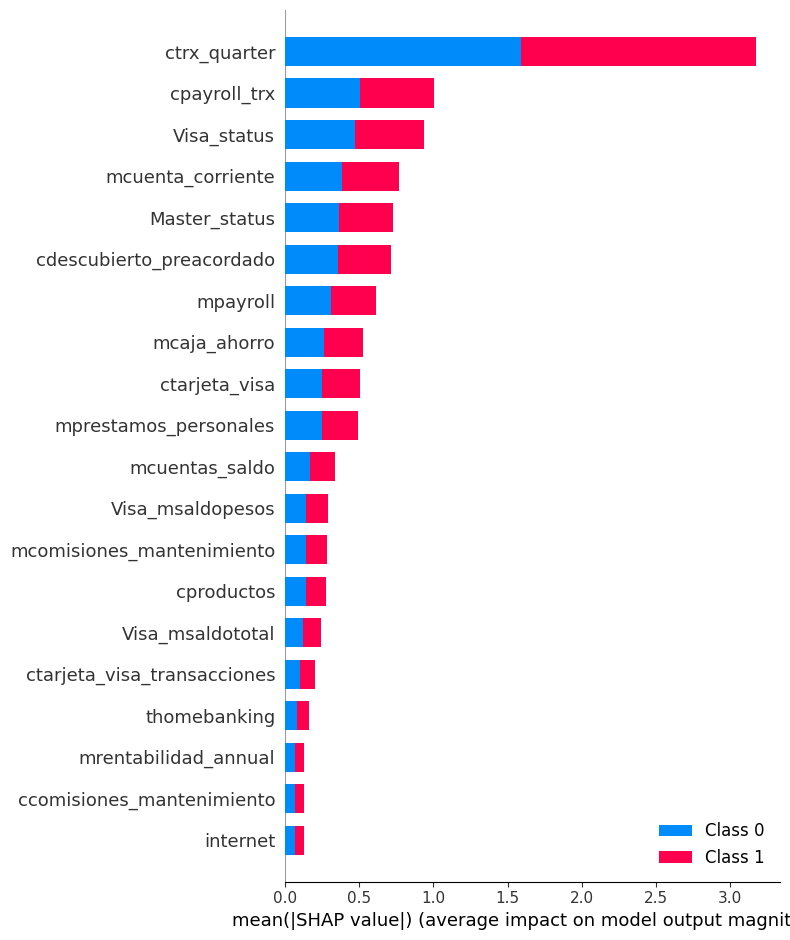

In [161]:
summary_plot = shap.summary_plot(shap_values_c1, Xbajas_c1)

In [162]:
df1_shap_imp = pd.DataFrame({'column': shap_importancias_c1.index, 'value': shap_importancias_c1.values})
df1_shap_imp[0:20]

,column,value
0,ctrx_quarter,1.588554
1,cpayroll_trx,0.503617
2,Visa_status,0.469043
3,mcuenta_corriente,0.384423
4,Master_status,0.365166
5,cdescubierto_preacordado,0.357701
6,mpayroll,0.307367
7,mcaja_ahorro,0.262979
8,ctarjeta_visa,0.252595
9,mprestamos_personales,0.247485


### cluster 2

In [165]:
Xbajas_c2 = Xbajas[Xbajas['cluster'] == 2]
Xbajas_c2 = Xbajas_c2.drop("cluster", axis = 1)
shap_values_c2 = explainer.shap_values(Xbajas_c2)
shap_bajas_c2 = pd.DataFrame(shap_values_c2[0], columns = Xbajas_c2.columns)
shap_importancias_c2 = shap_bajas_c2.abs().mean().sort_values(ascending=False)
shap_importancias_c2

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


cpayroll_trx                 0.557315
ctrx_quarter                 0.427170
mpayroll                     0.332504
mprestamos_personales        0.216493
mcomisiones_mantenimiento    0.164965
                               ...   
Master_delinquency           0.000000
Master_Finiciomora           0.000000
cprestamos_prendarios        0.000000
Master_msaldodolares         0.000000
cforex_sell                  0.000000
Length: 152, dtype: float64

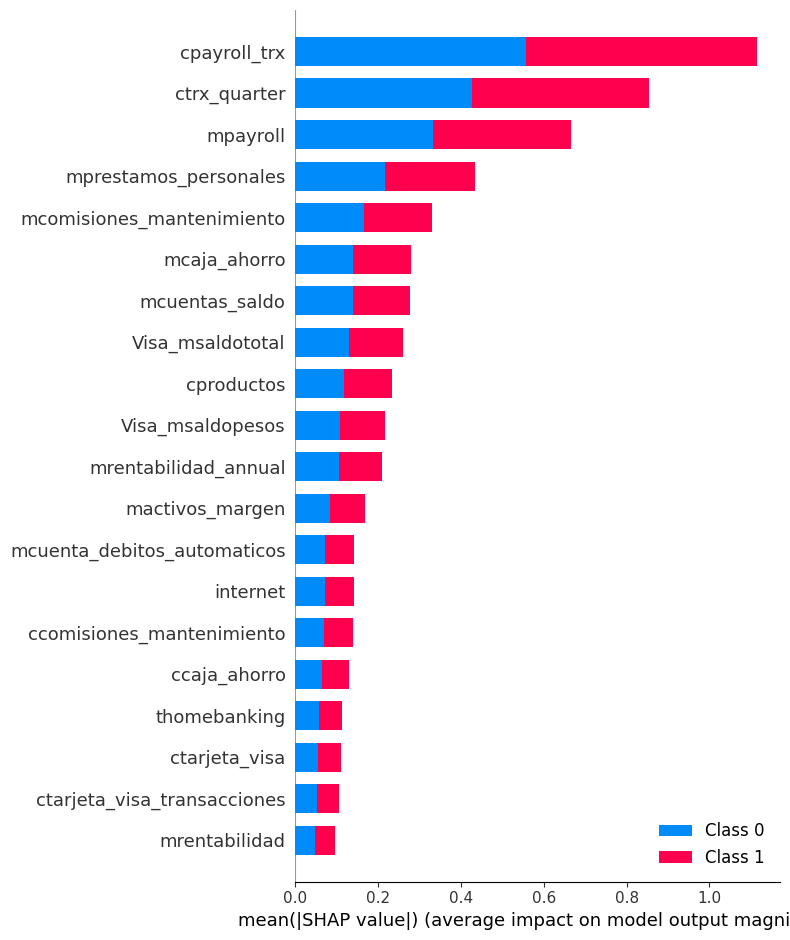

In [166]:
summary_plot = shap.summary_plot(shap_values_c2, Xbajas_c2)

In [167]:
df2_shap_imp = pd.DataFrame({'column': shap_importancias_c2.index, 'value': shap_importancias_c2.values})
df2_shap_imp[0:20]

,column,value
0,cpayroll_trx,0.557315
1,ctrx_quarter,0.427170
2,mpayroll,0.332504
3,mprestamos_personales,0.216493
4,mcomisiones_mantenimiento,0.164965
5,mcaja_ahorro,0.139101
6,mcuentas_saldo,0.138812
7,Visa_msaldototal,0.129581
8,cproductos,0.117182
9,Visa_msaldopesos,0.108341
